#CafChem tools for Creating Transformer-encoder classification models with HuggingFace.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MauricioCafiero/CafChem/blob/main/notebooks/BertClassifier_CafChem.ipynb)

## This notebook allows you to:
- Read in a dataset from a CSV, push it to the HuggingFace hub.
- Load a foundation model, add tokens to the tokenizer.
- Encode the dataset.
- Train a classification model.
- Evaluate with a confusion matrix.


## Requirements:
- This notebook will install datasets.
- It will pull the CafChem tools from Github.
- It will install all needed libraries.
- Use at least an L4 GPU for acceleration.

## Set-up

### Install Datasets

In [38]:
! pip install datasets --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

### Import libraries and pull CafChem from Github

In [1]:
!git clone https://github.com/MauricioCafiero/CafChem.git

Cloning into 'CafChem'...
remote: Enumerating objects: 279, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 279 (delta 105), reused 36 (delta 36), pack-reused 127 (from 1)
Receiving objects: 100% (279/279), 2.16 MiB | 20.89 MiB/s, done.
Resolving deltas: 100% (154/154), done.


In [2]:
import pandas as pd
import huggingface_hub
import numpy as np

import CafChem.CafChemHFClassifier as cchf

## Prepare dataset and foundation model

In [3]:
tyr_data = cchf.make_dataset("/content/tyrosinase_3classes_aug.csv", ["text","label"])

In [4]:
label_dict = {0: '< 2.5 uM', 1: '< 50 uM', 2: '> 50 uM'}
label_list = ["< 2.5 uM", "< 50 uM", "> 50 uM"]

ft_model, tokenizer, device = cchf.setup_foundation("cafierom/bert-base-cased-ChemTok-ZN250K-V1", 3, label_dict)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cafierom/bert-base-cased-ChemTok-ZN250K-V1 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
encoded_tyr = cchf.encode_dataset(tyr_data, tokenizer)

Map:   0%|          | 0/1053 [00:00<?, ? examples/s]

Map:   0%|          | 0/186 [00:00<?, ? examples/s]

## Set up classifer and train

In [6]:
model_name = "cafierom/bert-base-cased-ChemTok-ZN250K-V1"
tyr_classifer_3 = cchf.classify(f"{model_name}-tyrosinase_3classes", ft_model, tokenizer, encoded_tyr, 1)

Defining training model


In [7]:
trainer = tyr_classifer_3.train(0.02)

/content/CafChem/CafChemHFClassifier.py:145: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=self.ft_model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.055700,0.981361,0.526882,0.525841


## Evaluate Classifier

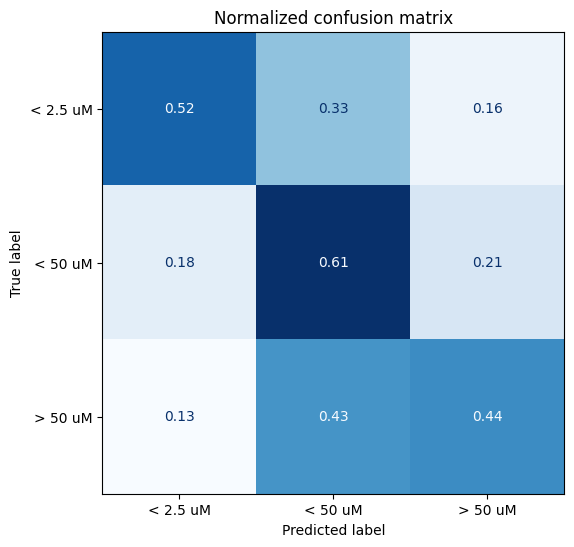

In [8]:
eval = cchf.evaluate(trainer, label_list, encoded_tyr)
eval.confusion()